In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import store

from inference.nlme_objective import ObjectiveFunctionNLME
from inference.ploting_routines import visualize_pesto_result
from inference.helper_functions import compute_error_estimate

In [43]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 
              'pharmacokinetic_model', 
              'clairon_small_model'][0]

INFO:root:Performing 2 pilot runs with the SimpleFroehlichModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 180, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...


using 2 layers of MultiConv1D, a  LSTM with 256 units and a dense layer with output dimension 12 as summary network
using a 6-layer cINN as inference network with 2 layers of design affine
prior mean: [-3.  -3.   5.   0.   0.  -0.1]
prior covariance diagonal: [ 5.  5. 11.  2.  6.  2.]
Using the model SimpleFroehlichModel


INFO:root:Done.


Model: "amortized_posterior_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_2 (Inver  multiple                 454872    
 tibleNetwork)                                                   
                                                                 
 sequence_network_2 (Sequenc  multiple                 306476    
 eNetwork)                                                       
                                                                 
Total params: 761,348
Trainable params: 761,276
Non-trainable params: 72
_________________________________________________________________
None


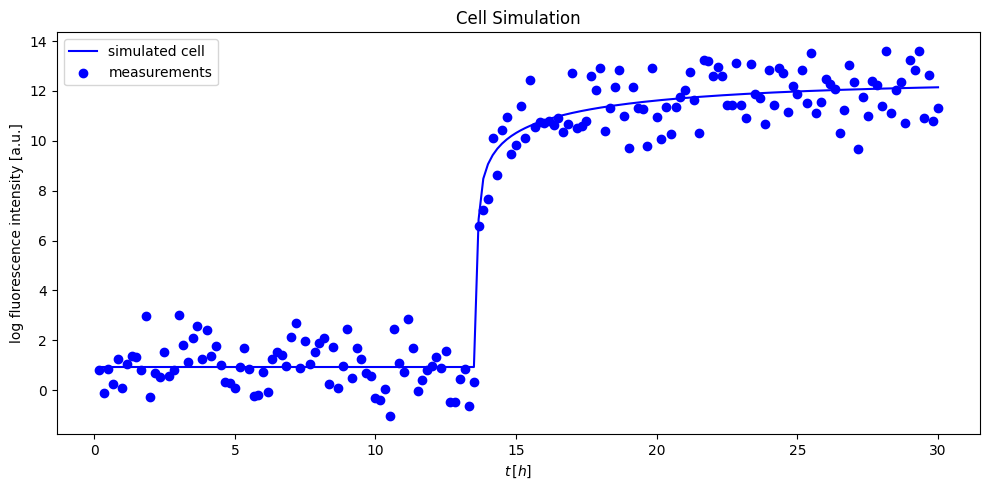

In [44]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    individual_model = ClaironSmallModel(load_best=True)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

In [45]:
obj_fun_amortized = ObjectiveFunctionNLME(model_name=individual_model.name,
                                          param_samples=np.empty((1,1,1)),
                                          prior_mean=individual_model.prior_mean,
                                          prior_std=individual_model.prior_std,
                                          covariance_format='diag',
                                          covariates=None,
                                          covariate_mapping=None,
                                          prior_type=individual_model.prior_type,
                                          prior_bounds=individual_model.prior_bounds if hasattr(individual_model, 'prior_bounds') else None,  # for uniform prior
                                          )

In [46]:
# load results
filename = '../output/test_results.hdf5'
result_optimization = store.read_result(filename)

This problem is not to be used without a separately created objective.
INFO:pypesto.store.read_from_hdf5:WARNING: You are loading a problem.
This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within ../output/test_results.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within ../output/test_results.hdf5.


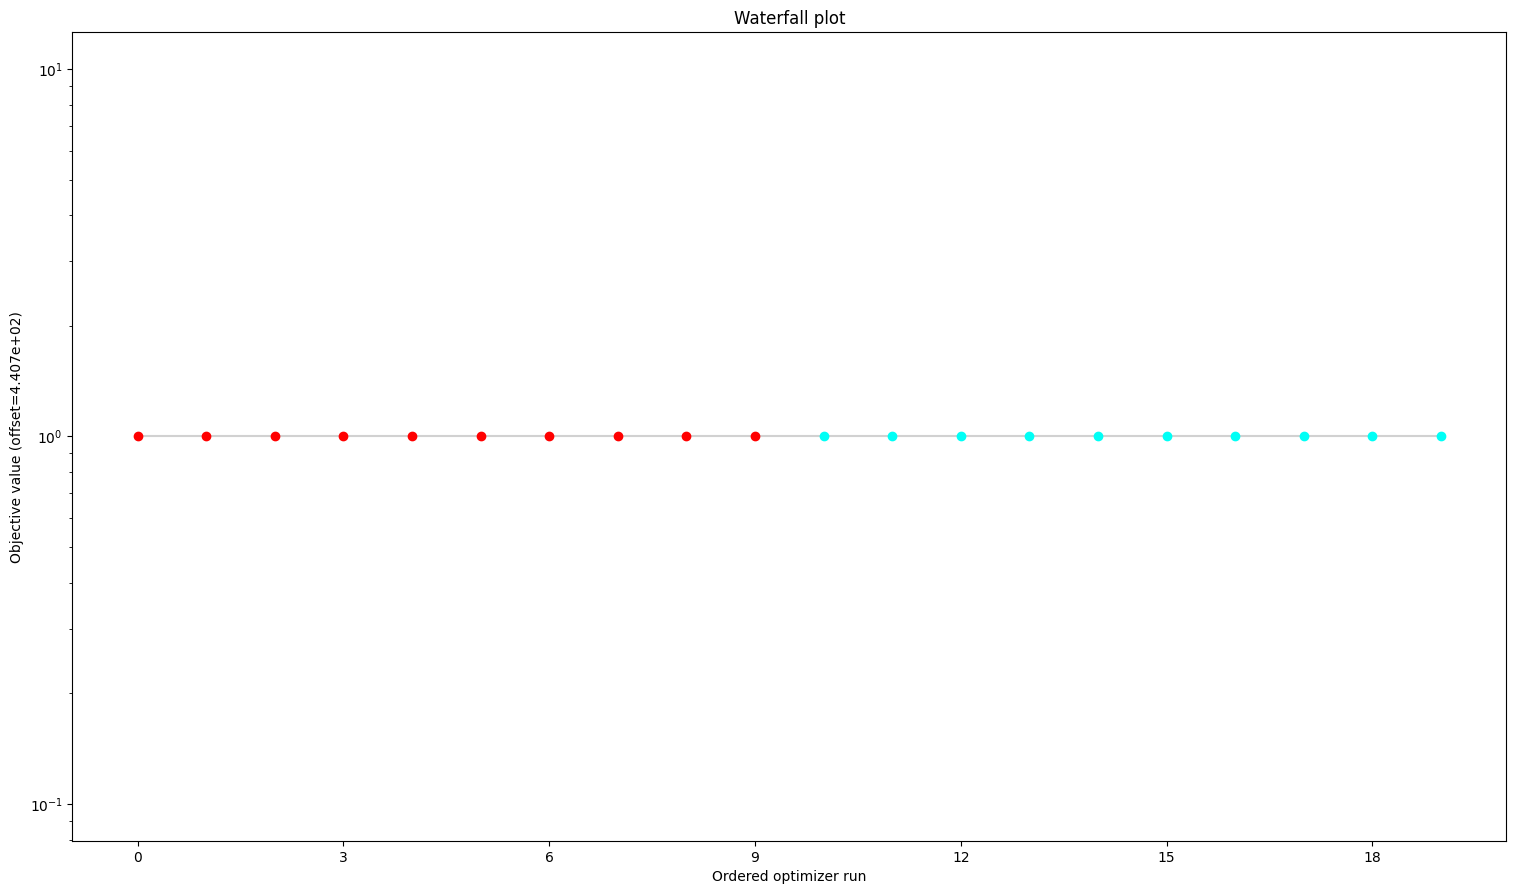

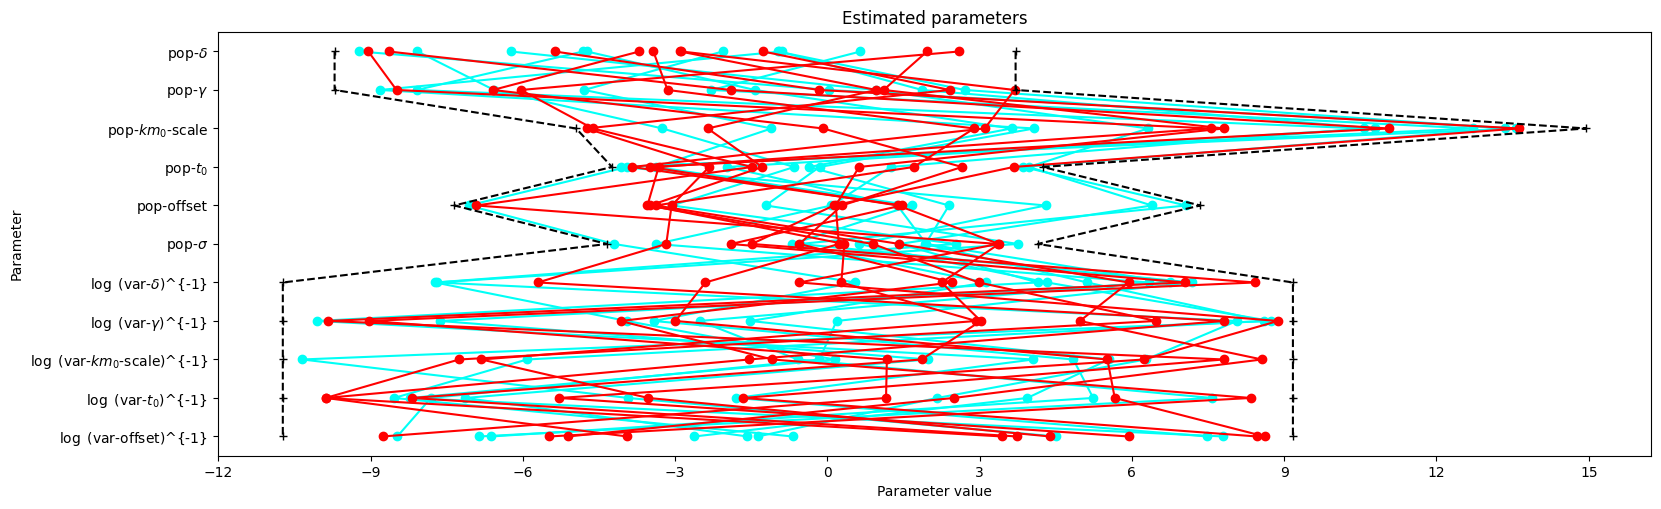

In [47]:
visualize_pesto_result(result_optimization)

In [56]:
test_n_cells = [50, 100, 200, 500, 1000, 5000, 10000]
n_samples_opt_list = [10, 50, 100, 1000]
n_runs = 20 #100
time_opt = np.zeros((len(test_n_cells), len(n_samples_opt_list), n_runs))
rel_error = np.zeros((len(test_n_cells), len(n_samples_opt_list), n_runs))

    
for nc, n_cells in enumerate(test_n_cells):
    for ns, n_samples in enumerate(n_samples_opt_list):
        # load results
        #filename = f'output/scalability/{individual_model.name}_cells_{n_cells}_samples_{n_samples}.hd5'
        filename =  '../output/test_results.hdf5'
        result_optimization = store.read_result(filename)
        results_params = np.array(result_optimization.optimize_result.x)
        assert results_params.shape[0] == n_runs
                
        # load true population parameters
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_cells)
        
        for i_r, res in enumerate(results_params):
            # transform results
            estimated_beta = res[:individual_model.n_params]
            estimated_var = np.exp(-res[individual_model.n_params:individual_model.n_params*2])
            estimated_params = np.concatenate((estimated_beta, estimated_var))
             
            # compute relative error of parameter estimated as minimum over multi_starts
            rel_error[nc, ns, i_r] = compute_error_estimate(estimated_params,
                                                            true_pop_parameters,
                                                            bi_modal=True if 'Simple' in individual_model.name else False)
             
        # get duration of optimization procedure (in seconds)
        time_opt[nc, ns, :] = result_optimization.optimize_result.time / 60 / 60
        break
    break

This problem is not to be used without a separately created objective.
INFO:pypesto.store.read_from_hdf5:WARNING: You are loading a problem.
This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within ../output/test_results.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within ../output/test_results.hdf5.
/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_2882/493086665.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rel_error[nc, ns, i_r] = compute_error_estimate(estimated_params,


In [70]:
# read results from monolix
compute_relative_error = False  # relative to true parameter values
epsilon = 1e-4

monolix_small_errors = np.zeros(len(test_n_cells))
full_error_list_small = []
n_cells_opt_list_monolix_small = np.array(test_n_cells)[[0,1,2,3,5,6]]
for cell_idx, n_cells in enumerate(test_n_cells):
    if n_cells == 1000: continue  # TODO: missing Clemens
    results_monolix = pd.read_csv(f'results_monolix/simple_model/estimated_parameters_synthetic_{n_cells}_cells.csv',
                                 index_col=0, header=0)
    true_sample_parameters = pd.read_csv(f'../data/synthetic/sample_pop_parameters.csv',
                                      index_col=0, header=0).loc[f'{n_cells}'].values

    results_to_compare = []
    for col in results_monolix.columns:
        temp_res = results_monolix[col].values[[0,1,2,3,4,10,5,6,7,8,9]]
        temp_res[5] = np.log(temp_res[5])
        temp_res = np.concatenate((temp_res, [0]))
        results_to_compare.append(temp_res)
    error_mono = compute_error_estimate(np.array(results_to_compare), true_sample_parameters, bi_modal=True,
                                        relative_error=compute_relative_error)
    full_error_list_small.append(np.array(results_to_compare)-true_sample_parameters)
    error_mono.sort()
    monolix_small_errors[cell_idx] = np.min(error_mono[:10])

monolix_large_errors = np.zeros(len(test_n_cells))
full_error_list_large = []
n_cells_opt_list_monolix_large = [50, 100, 500, 5000, 10000]
for cell_idx, n_cells in enumerate(test_n_cells):
    if n_cells == 1000: continue  # TODO: missing Clemens
    if n_cells == 200: continue  # TODO: missing Clemens
    results_monolix = pd.read_csv(f'results_monolix/detailed_model/synthetic_{n_cells}_poppars.csv',
                                 index_col=0, header=0)
    true_sample_parameters = pd.read_csv(f'../data/synthetic/sample_pop_parameters_detailed_model.csv',
                                      index_col=0, header=0).loc[f'{n_cells}'].values
    results_to_compare = []
    for col in results_monolix.columns:
        temp_res = results_monolix[col].values[[0,1,2,3,4,5,6,7,8,9,20,10,11,12,13,14,15,16,17,18,19]]
        temp_res[10] = np.log(temp_res[10])
        temp_res = np.concatenate((temp_res, [0]))
        results_to_compare.append(temp_res)
    error_mono = compute_error_estimate(np.array(results_to_compare), true_sample_parameters,
                                        relative_error=compute_relative_error, epsilon=epsilon)
    full_error_list_large.append(np.array(results_to_compare)-true_sample_parameters)
    error_mono.sort()
    monolix_large_errors[cell_idx] = np.min(error_mono[:10])

time_monolix_small = pd.read_csv(f'results_monolix/simple_model/average_optimal_timings.csv', index_col=1, header=0)['average_time'] # already in hours
time_monolix_large = np.zeros(len(n_cells_opt_list_monolix_large))
for cell_idx, n_cells in enumerate(n_cells_opt_list_monolix_large):
    best_runs = pd.read_csv(f'results_monolix/detailed_model/synthetic_{n_cells}_complete_likelihoods.csv', index_col=0, header=0)['run'].values[:10]
    time_monolix_large_full = pd.read_csv(f'results_monolix/detailed_model/synthetic_{n_cells}_timings.csv', header=0)
    for run in time_monolix_large_full.values:
        if run[-1] in best_runs:
            time_monolix_large[cell_idx] += run[0]
    # sort by ll
    time_monolix_large[cell_idx] = time_monolix_large[cell_idx] / best_runs.size
time_monolix_large = time_monolix_large / 60 / 60  # in hours

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(15, 5))

for j, n_samples_opt in enumerate(n_samples_opt_list):
    axis[0].plot(test_n_cells, rel_error[:, j], label=f'#posterior samples: {n_samples_opt}')
    axis[1].scatter(np.array(test_n_cells) * n_samples_opt, rel_error[:, j],
                    label=f'#posterior samples: {n_samples_opt}')

axis[0].plot(test_n_cells, monolix_errors, label=f'baseline')

axis[0].set_ylabel('$t\,[s]$')
axis[0].set_ylabel('Relative mean squared error')
axis[0].set_xscale('log')
axis[1].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_title('Error (compared to true population parameters)')
axis[1].set_title('Error (compared to true population parameters)')
axis[0].set_xlabel('#cells')
axis[0].set_xticks(ticks=test_n_cells, rotation=60)
axis[1].set_xlabel('#cells $\cdot$ #posterior samples')
axis[0].legend()
axis[1].legend()
#axis[1].set_ylim(0, 8)
plt.tight_layout()

if multi_experiments:
    pass
    #plt.savefig('plots/real_time_error_vs_#cells_#samples.png')
else:
    pass
    #plt.savefig('plots/synthetic_time_error_vs_#cells_#samples.png')
plt.show()
time_monolix = pd.read_csv(f'output/results_monolix/average_optimal_timings.csv', index_col=1, header=0)['average_time']
figure, axis = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(15, 5))

axis[0].hlines(4.2, xmin=test_n_cells[0], xmax=test_n_cells[-1], color='grey', linestyle='--',
               label=f'average training time of BayesFlow')

for j, n_samples_opt in enumerate(n_samples_opt_list):
    axis[0].plot(test_n_cells, time_opt[:, j] / 60 / 60, label=f'#posterior samples: {n_samples_opt}')
    axis[1].scatter(np.array(test_n_cells) * n_samples_opt, time_opt[:, j] / 60 / 60,
                    label=f'#posterior samples: {n_samples_opt}')

axis[0].plot(test_n_cells, time_monolix, label=f'baseline')

# joint settings
axis[0].set_ylabel('$t\,[h]$')
#axis[0].set_yscale('log')
#axis[1].set_yscale('log')
axis[0].set_xscale('log')
axis[1].set_xscale('log')
axis[0].set_title('Optimization Time For a New Data Set')
axis[1].set_title('Optimization Time For a New Data Set')
axis[0].legend()
axis[1].legend()

# other settings
axis[0].set_xlabel('#cells')
axis[0].set_xticks(ticks=test_n_cells, rotation=60)
axis[1].set_xlabel('#cells $\cdot$ #posterior samples')
#axis[1].set_ylim(1e-3, 1e6)
plt.tight_layout()
#plt.savefig('plots/synthetic_time_vs_#cells_#samples.png')
plt.show()